# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import torch.distributions.normal as dist

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
from torchvision import transforms

env_info = env.reset(train_mode=True)[brain_name]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
#print(states)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
sample_states = []
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1    
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    #print('action:',actions,'next states',next_states,'reward:',rewards)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    sample_states.append(states)
    if np.any(dones):                                  # exit loop if episode finished
        break
    print('a state=',states)
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

a state= [[ 3.68537903e-02 -3.99847198e+00  1.15016937e-01  9.99887228e-01
   4.58357204e-03 -5.51861267e-05  1.43062500e-02 -5.69000065e-01
   3.15614650e-03  1.82959676e-01  7.35626161e-01  4.35043834e-02
   2.28702879e+00  6.18171692e-02 -9.99278927e+00  1.21002197e-02
   9.99504924e-01 -4.17031406e-04 -3.64054198e-04 -3.14582214e-02
   1.25272202e+00  2.07601599e-02 -1.57768410e-02  1.21083188e+00
   2.87471861e-01 -1.58370912e+00  7.11806488e+00 -1.00000000e+00
  -3.65145874e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-1.29890442e-01 -3.99733901e+00  9.23156738e-02  9.99803543e-01
  -1.61556024e-02  1.56283641e-04  1.14847831e-02 -4.57154870e-01
  -8.89210217e-03 -6.42424107e-01 -2.58248568e+00  7.57517144e-02
   1.83667171e+00 -4.67720032e-02 -9.99011230e+00  6.81953430e-02
   9.99428749e-01  2.99992599e-02  1.12431974e-03 -1.55231878e-02
   6.18320584e-01 -6.43367022e-02  1.19286013e+00  8.06376994e-01
   3.76058906e-01  4.64840621e-01  5.44112778e+0

a state= [[ 5.71304321e-01 -1.57218838e+00 -3.64813232e+00  8.34531605e-01
   5.95814921e-02  3.90498787e-02 -5.46335340e-01  1.21361172e+00
   2.75239974e-01 -1.28164172e-01 -1.20747674e+00  4.29905367e+00
  -2.20136929e+00 -1.22626877e+00 -4.27780914e+00 -5.04709625e+00
   8.38338494e-01 -3.47137719e-01  2.23810598e-01  3.55798870e-01
   2.98413455e-01  2.68242449e-01 -2.08626941e-01 -2.05244255e+00
   7.60997486e+00 -3.63038492e+00  6.92921066e+00 -1.00000000e+00
  -3.99825287e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-8.85101318e-01 -2.90668035e+00  2.61045837e+00  9.28670526e-01
  -1.03502296e-01  3.94345634e-02  3.53982151e-01  2.42255583e-01
   4.14974034e-01  4.60431039e-01  2.42369652e+00 -1.06431794e+00
  -3.15985858e-01 -6.10580444e-01 -7.94303608e+00  4.67254639e+00
   9.84430552e-01  1.59003735e-01  7.45479465e-02  7.54161132e-03
  -1.89329243e+00  9.17432487e-01 -1.43735528e+00 -1.76198924e+00
  -3.95806336e+00  6.00386238e+00  7.40491867e+0

a state= [[ 3.43505859e-01 -9.79541421e-01 -3.87910843e+00  7.89693713e-01
   3.37855667e-02  2.62150466e-02 -6.12009108e-01  7.32733905e-01
   3.27343136e-01 -8.94549415e-02 -1.35857069e+00  2.79656839e+00
  -8.94678831e-01 -1.64293289e+00 -3.39356971e+00 -5.68209076e+00
   8.65663767e-01 -3.76634955e-01  1.68579653e-01  2.83466697e-01
   1.65357149e+00  7.08692670e-02 -3.39525551e-01 -3.08143759e+00
   3.20184660e+00 -5.36701155e+00  6.90717697e+00 -1.00000000e+00
  -4.03620148e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-2.87662506e-01 -3.37956357e+00  2.13304520e+00  9.60396051e-01
  -3.44591253e-02  9.70515050e-03  2.76329249e-01  1.77005148e+00
   6.07206702e-01  8.93752277e-01  4.32784986e+00 -4.32078457e+00
  -5.63568687e+00 -6.53297424e-01 -8.56216431e+00  5.17924881e+00
   9.68268394e-01 -2.40190625e-02  5.17451297e-03  2.48701736e-01
  -4.15522575e+00 -4.23546851e-01 -2.78171539e+00 -4.59425306e+00
  -5.80584966e-02  7.17034483e+00  6.93182373e+0

a state= [[ 9.67845917e-01 -3.83639526e+00  5.96336365e-01  9.89699721e-01
   1.20915689e-01 -9.30996519e-03  7.60742351e-02 -7.55375147e-01
  -2.81805806e-02 -2.02359691e-01 -7.96514153e-01  2.06992328e-01
   2.94442892e+00 -1.30611038e+00 -6.68913984e+00  8.83670807e-01
  -7.58902952e-02  3.92845236e-02  7.00192809e-01  7.08821177e-01
   1.85077906e+00  8.21064830e-01  5.24257302e-01 -1.68340397e+00
  -1.39407682e+00  8.92346287e+00  6.63901138e+00 -1.00000000e+00
  -4.46357727e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.35945892e+00 -2.97910976e+00 -1.26459122e+00  9.32349920e-01
   3.02389622e-01  6.11519367e-02 -1.88533142e-01 -1.84970513e-01
  -9.19375494e-02  2.15566233e-01  7.65234053e-01  2.68566459e-01
   7.71164596e-01  2.18675232e+00 -7.46825552e+00 -1.74871826e+00
   8.42038631e-01 -2.75031924e-01  4.06709641e-01  2.23418012e-01
   2.83830070e+00  8.40270996e-01  3.49925578e-01  3.17223024e+00
  -2.87771559e+00 -5.50864697e+00 -3.83022308e+0

a state= [[ 3.93321991e-01 -2.80602098e+00  2.83328247e+00  9.22525167e-01
   4.52354588e-02 -1.87816452e-02  3.82816494e-01 -1.12160945e+00
  -5.32350354e-02 -5.55481054e-02 -3.07832748e-01  3.08279872e+00
   3.26122999e+00 -2.01696777e+00 -6.21858358e+00  4.92555237e+00
  -8.41576397e-01  5.28684318e-01  9.14739817e-02  6.22468069e-02
   3.31996036e+00  3.48017737e-02  8.55611444e-01  1.05018210e+00
   1.62433553e+00 -3.38664919e-01  6.53948975e+00 -1.00000000e+00
  -4.60815430e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 1.08226013e+00 -3.83520007e+00 -3.59676361e-01  9.89656687e-01
   1.35710612e-01  6.32604398e-03 -4.60694395e-02  1.28544182e-01
   5.83459325e-02 -6.43560350e-01 -2.49282169e+00 -6.83983684e-01
  -5.59924841e-01  1.00970078e+00 -8.06408691e+00 -3.15772629e+00
   8.32053840e-01 -6.26519322e-02 -1.81676283e-01 -5.20341098e-01
   2.43345022e-01 -5.50366879e-01 -3.80661339e-01 -3.07381511e+00
   2.21164122e-01 -2.20662880e+00 -6.88899231e+0

a state= [[-2.35145569e-01 -3.80900240e+00  1.20213699e+00  9.88031089e-01
  -2.89216582e-02  4.43454226e-03  1.51454434e-01 -4.35321063e-01
   6.15775865e-03  2.02439595e-02  8.49174485e-02  5.03604174e-01
   1.67285872e+00 -1.66156769e-01 -9.27393246e+00  3.57004547e+00
  -9.66308117e-01 -3.78342457e-02  1.65612604e-02 -2.54053175e-01
   1.84841895e+00  3.13663781e-01  7.67711043e-01  3.78888655e+00
  -3.20040393e+00 -4.17738104e+00  6.22225189e+00 -1.00000000e+00
  -5.02827454e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-2.47204208e+00 -2.51182008e+00 -1.90787125e+00  8.96803260e-01
  -3.08328837e-01 -1.03156410e-01 -3.00059915e-01 -2.18913659e-01
  -1.64166778e-01  2.15847179e-01  8.56032372e-01 -9.55664515e-01
   1.41344622e-01 -4.99599457e+00 -7.31998634e+00 -3.18332291e+00
   9.71557975e-01 -1.16646878e-01 -2.06078261e-01  6.93656970e-04
  -6.49297059e-01  3.03190015e-03 -1.64016649e-01  7.83506989e-01
  -1.39917755e+00  3.06779456e+00 -3.76144028e+0

a state= [[ 2.02015686e+00 -3.38338733e+00 -7.06371307e-01  9.60502326e-01
   2.58858472e-01  2.65496802e-02 -9.86043289e-02  5.03053784e-01
  -9.20142755e-02  4.66852546e-01  1.66297865e+00  1.26787543e+00
  -1.54203904e+00  1.41841888e+00 -7.44486380e+00  2.63320923e-01
  -7.36249387e-01  1.91134959e-01 -4.60052758e-01 -4.57991064e-01
  -9.66190815e-01 -1.54442370e+00  1.68250889e-01 -2.21565709e-01
   3.89407110e+00 -5.21826220e+00  6.11046600e+00 -1.00000000e+00
  -5.16354752e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-1.72090530e+00 -3.60135198e+00 -3.18511963e-01  9.74726260e-01
  -2.19059795e-01 -9.59761068e-03 -4.27728817e-02 -1.07758842e-01
  -1.42471313e-01  1.58690369e+00  5.70057154e+00 -2.94920897e+00
   1.22319713e-01 -2.78110123e+00 -9.08599186e+00 -1.66192627e+00
   9.78704274e-01  2.38111112e-02  7.46046752e-02 -1.89750239e-01
  -8.66661429e-01  1.53706694e+00 -8.24773967e-01  3.96242952e+00
  -6.99789667e+00  3.06283808e+00  3.89533997e-0

a state= [[ 2.02308655e+00 -3.37131143e+00  7.59506226e-01  9.59601760e-01
   2.58967340e-01 -2.87152324e-02  1.06188044e-01  4.13509220e-01
   2.74995983e-01  1.17550492e+00  4.25267935e+00  1.94805539e+00
  -1.95169723e+00  4.14368439e+00 -8.53709030e+00  1.07231140e-02
  -9.58757281e-01 -1.35866359e-01  1.37098849e-01  2.08635345e-01
  -2.57616186e+00  5.16491950e-01 -1.34669483e+00  1.23276246e+00
  -3.50703597e+00  5.78881216e+00  5.75768280e+00 -1.00000000e+00
  -5.55419540e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.68743896e+00 -2.07432055e+00  2.13354492e+00  8.60985398e-01
   3.30092192e-01 -1.38527945e-01  3.61321509e-01  1.06087878e-01
   7.61714354e-02  7.44521394e-02  3.19052666e-01 -2.76388805e-02
  -4.26345110e-01  7.22341537e+00 -4.95226860e+00  4.65737915e+00
   8.24524879e-01  4.40709382e-01 -1.98271766e-01  2.94316739e-01
  -5.98566234e-02 -1.16913565e-01  6.55548349e-02  5.25145590e-01
   2.80226886e-01 -1.87886760e-01  7.96577454e+0

a state= [[ 1.74797821e+00 -3.57730174e+00 -4.09473419e-01  9.73252356e-01
   2.22653508e-01  1.26022557e-02 -5.51958270e-02 -3.85831147e-01
   7.40657672e-02 -6.08028829e-01 -2.20430231e+00 -1.25777876e+00
   1.24554956e+00  3.51195908e+00 -8.10612965e+00  1.60876083e+00
  -8.88000429e-01 -1.49786979e-01 -1.36593387e-01 -4.12748486e-01
  -1.39507711e+00  7.82085598e-01  2.53203541e-01 -4.85924125e-01
   2.67768908e+00  5.65063429e+00  5.65002060e+00 -1.00000000e+00
  -5.66367722e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.65298843e+00 -2.48897266e+00  1.68250656e+00  8.95263910e-01
   3.37356091e-01 -1.02583408e-01  2.72341996e-01  8.20478261e-01
  -2.61318386e-01 -3.76435846e-01 -1.37318921e+00 -2.41131806e+00
  -1.31908286e+00  7.17035294e+00 -5.33918333e+00  4.20715714e+00
   8.04668903e-01  4.73513603e-01 -1.24274410e-01  3.35929751e-01
  -2.82146305e-01 -2.18434677e-01  9.97407854e-01 -1.27114093e+00
   5.06954677e-02 -1.05137706e+00  6.76329041e+0

a state= [[-1.23315048e+00 -3.70245767e+00 -8.86131287e-01  9.81138051e-01
  -1.54201135e-01 -1.80899426e-02 -1.15165360e-01  5.83328128e-01
   3.73794064e-02 -1.65584669e-01 -6.50285184e-01  6.94171667e-01
  -2.13414574e+00 -4.52129364e+00 -7.37241554e+00  6.42929077e-02
  -8.03577900e-01  4.66497004e-01 -5.41072600e-02 -3.65671307e-01
   4.68556255e-01  1.55995488e-01 -7.28157684e-02 -8.57125938e-01
   3.46538633e-01 -3.78961349e+00  5.24881363e+00 -1.00000000e+00
  -6.03738022e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 4.88395691e-01 -3.71372747e+00 -1.41051102e+00  9.81911540e-01
   5.98449968e-02  1.09805688e-02 -1.79298133e-01 -5.20435393e-01
  -3.60549271e-01  9.25808728e-01  3.97494221e+00 -3.78996342e-01
   2.08688188e+00  1.62863541e+00 -9.03090096e+00 -3.89223862e+00
   9.59183753e-01  1.28005013e-01  2.47893110e-02 -2.50931621e-01
   1.39248276e+00  1.49773848e+00 -2.19781494e+00 -4.28126764e+00
  -9.42158282e-01 -3.65709877e+00 -4.99664688e+0

a state= [[-7.62432098e-01 -3.85649371e+00 -7.43927002e-01  9.90982771e-01
  -9.48352963e-02 -9.00685322e-03 -9.42255333e-02 -4.33290720e-01
  -4.73808572e-02  2.35852227e-01  9.48671997e-01 -5.20786464e-01
   1.63821006e+00 -4.25156021e+00 -7.32478333e+00 -9.08939362e-01
  -7.71282673e-01  6.27245784e-01 -2.57523265e-02 -1.04988813e-01
   2.35781121e+00 -6.51274264e-01 -1.63782686e-01  1.07997227e+00
  -1.79104543e+00 -1.92598188e+00  5.13197327e+00 -1.00000000e+00
  -6.13700867e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 1.02037430e+00 -3.60199308e+00 -1.41586304e+00  9.74616230e-01
   1.25735447e-01  2.36911289e-02 -1.83718801e-01 -1.30671322e-01
   2.92678326e-01 -7.43164718e-01 -3.09258223e+00 -9.90016520e-01
   1.53876171e-01 -5.30914307e-01 -7.11770344e+00 -4.20284271e+00
   7.11943567e-01 -2.69061863e-01 -3.58565360e-01 -5.40530205e-01
   3.67194384e-01  1.45201340e-01 -6.53547645e-01 -6.60346889e+00
   1.44410741e+00  2.97590524e-01 -7.28746414e+0

a state= [[ 1.11815643e+00 -3.23520136e+00  2.07715988e+00  9.50428784e-01
   1.34836808e-01 -3.93623635e-02  2.77407169e-01  2.40824506e-01
   1.24108143e-01  1.92257121e-01  8.84899616e-01 -2.93732047e-01
  -9.18826997e-01  4.66204071e+00 -5.41390324e+00  2.35656357e+00
  -6.45425081e-01 -5.42773247e-01 -2.03700319e-01  4.97322768e-01
   4.78290272e+00  7.35733688e-01 -2.11368769e-01  2.30421290e-01
   7.47004175e+00 -3.56898236e+00  4.68178558e+00 -1.00000000e+00
  -6.48697662e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-7.37380981e-03 -3.31447172e+00  2.24623108e+00  9.56391633e-01
  -8.69086944e-04  2.94303754e-04  2.92085886e-01 -6.57122850e-01
   2.31929153e-01  3.54199618e-01  1.70210803e+00  1.43256962e+00
   2.21976328e+00 -1.70183945e+00 -7.72088861e+00  2.35043335e+00
   8.99950624e-01 -2.77758360e-01 -9.81990620e-02 -3.21397275e-01
   1.09868836e+00  1.51472777e-01  4.47818279e-01  3.91448379e+00
   3.87417436e+00  1.09990525e+00 -1.95463943e+0

a state= [[ 2.40652084e+00 -2.86815977e+00  1.42617798e+00  9.24098790e-01
   3.07121396e-01 -7.17787147e-02  2.15790689e-01  1.01905477e+00
   2.53114194e-01  4.86866355e-01  1.78183448e+00 -3.71638060e-01
  -3.53633022e+00  6.97047424e+00 -4.89946318e+00  1.33636856e+00
  -6.85749710e-01 -6.97640359e-01  9.38798934e-02  1.85018450e-01
  -1.25152242e+00 -1.19003797e+00  1.18030989e+00  5.10448027e+00
   1.89194357e+00 -1.49936712e+00  4.57443619e+00 -1.00000000e+00
  -6.56311798e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 4.51614380e-01 -2.86592007e+00  2.76198959e+00  9.26552117e-01
   5.22113442e-02 -2.09566597e-02  3.71935636e-01 -3.20141315e-01
   3.96127664e-02  4.19234931e-02  2.30433315e-01  8.97165895e-01
   9.11947191e-01 -8.95938873e-01 -7.26876497e+00  3.77230453e+00
   9.27036703e-01 -2.72618949e-01 -1.24278247e-01 -2.25470230e-01
   2.53202002e-02 -1.43497914e-01  3.89042437e-01  1.91696155e+00
   6.21017635e-01  1.14510834e+00  1.24956512e+0

a state= [[-1.15771103e+00 -3.74383688e+00 -8.21998596e-01  9.83651817e-01
  -1.44691363e-01 -1.54487640e-02 -1.06089383e-01  1.62146068e+00
   1.79194868e-01 -9.76002693e-01 -3.84339333e+00  2.19528866e+00
  -5.98208046e+00 -4.17301178e-01 -8.94148350e+00 -2.32493591e+00
  -9.43172872e-01 -2.69396156e-01 -7.89290741e-02  1.77822590e-01
  -4.96980476e+00  2.06917310e+00 -7.48879313e-01 -1.24347506e+01
  -5.76429605e+00  1.03564334e+00  4.11414337e+00 -1.00000000e+00
  -6.86103821e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-7.74768829e-01 -3.46332932e+00  1.85153580e+00  9.65754092e-01
  -9.39461142e-02  2.34031789e-02  2.40718603e-01  3.42807859e-01
   1.59688532e-01  2.95020610e-01  1.32155657e+00 -8.79344344e-01
  -1.05965090e+00 -1.19430161e+00 -8.07911587e+00  1.00976944e+00
   9.08861578e-01 -1.42380791e-02  9.69287604e-02 -4.05429065e-01
   2.54581857e+00  1.46503106e-01  1.41484171e-01  2.29380989e+00
   6.50127029e+00 -9.92152500e+00  7.71444321e+0

a state= [[-1.38091660e+00 -3.69534445e+00 -6.73244476e-01  9.80719864e-01
  -1.73709288e-01 -1.56242037e-02 -8.81447345e-02  1.57980308e-01
  -1.28803402e-01  7.23670065e-01  2.76021743e+00 -9.34997559e-01
  -7.68984139e-01 -3.88315201e+00 -9.06347847e+00 -1.55147552e+00
  -9.64850426e-01  2.51801580e-01  2.44175158e-02  7.11583793e-02
  -7.85780430e-01  7.92861462e-01 -2.63741946e+00 -6.11264658e+00
   3.04644108e+00  3.32103300e+00  3.98170471e+00 -1.00000000e+00
  -6.93873596e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-2.76390076e-01 -3.98182869e+00 -2.82226562e-01  9.98789012e-01
  -3.43754999e-02 -1.21674920e-03 -3.51756252e-02  1.26157475e+00
  -2.13505374e-03  4.72476259e-02  1.89722702e-01  2.15208933e-01
  -5.05612516e+00 -2.13428497e-01 -6.45488453e+00 -3.43673325e+00
   6.41299605e-01  2.63479375e-03  5.64234927e-02 -7.65208721e-01
   6.93817616e-01 -1.59125999e-01  1.63985379e-02  1.01706648e+00
   3.42251730e+00 -8.27960777e+00  5.91350174e+0

a state= [[-1.08530807e+00 -3.25638413e+00  2.06232071e+00  9.51851130e-01
  -1.30923957e-01  3.77345569e-02  2.74616957e-01 -8.66139174e-01
  -2.29679853e-01 -3.78667891e-01 -1.71875405e+00  2.14139652e+00
   2.63250351e+00 -2.30510330e+00 -8.68129730e+00  3.66829681e+00
  -9.95160222e-01  6.72738627e-02 -6.97901398e-02 -1.61200427e-02
   8.57815862e-01 -5.14277637e-01  3.00613999e+00  1.00525808e+01
   9.70422328e-01  3.98054510e-01  3.51679230e+00 -1.00000000e+00
  -7.18555450e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-1.08882904e-01 -3.82515740e+00 -1.16963959e+00  9.89029229e-01
  -1.33923404e-02 -2.01620720e-03 -1.47097751e-01 -8.07025671e-01
   9.25501511e-02 -2.87597299e-01 -1.21443987e+00 -9.69369531e-01
   3.09588790e+00  5.57979584e-01 -7.02433920e+00 -4.92964172e+00
   7.39087403e-01  8.52341503e-02  9.31816027e-02 -6.61666274e-01
  -7.85149038e-01 -1.91048205e-01 -2.61835963e-01 -1.40828335e+00
  -5.35459042e+00  5.94183397e+00 -5.64216614e+0

a state= [[-1.01125336e+00 -2.86207271e+00  2.61376953e+00  9.25407410e-01
  -1.18296914e-01  4.56509888e-02  3.57131571e-01  5.33834174e-02
   1.44900575e-01  1.59270182e-01  8.36756945e-01 -3.03505063e-01
  -4.33770707e-03 -1.46686554e-01 -7.31148291e+00  3.50189972e+00
  -9.18515563e-01 -2.41198987e-01 -1.96866989e-01  2.43712336e-01
   1.65514028e+00 -1.09523451e+00  1.89952540e+00  9.85822296e+00
   6.22004890e+00 -3.43230820e+00  3.43777084e+00 -1.00000000e+00
  -7.22369385e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-5.75256348e-02 -3.96770883e+00 -5.05691528e-01  9.97986317e-01
  -7.14070909e-03 -4.48849984e-04 -6.30261451e-02 -1.02696031e-01
  -3.16216834e-02  2.46051848e-01  9.97089624e-01 -7.17327744e-02
   4.06942040e-01  4.84626770e-01 -8.58012009e+00 -3.33336258e+00
   8.77372742e-01  8.39480385e-02  5.09498455e-02 -4.69653010e-01
  -2.18696260e+00  3.69033426e-01  3.37345898e-02  4.40086067e-01
  -8.25874710e+00  5.33764982e+00 -6.94700241e+0

a state= [[ 2.80090332e+00 -2.05014849e+00 -2.00903702e+00  8.58792722e-01
   3.48385632e-01  1.41142592e-01 -3.48111182e-01 -7.77937829e-01
   5.74066043e-01 -5.73497534e-01 -2.30298734e+00 -3.19559741e+00
  -7.48093128e-02  2.91416931e+00 -5.77301884e+00 -2.90399933e+00
  -7.66907930e-01  2.31747225e-01 -5.23932457e-01 -2.89206386e-01
  -1.17425132e+00 -6.65189624e-01 -1.52053773e+00 -9.67147350e+00
  -2.80530512e-01  1.91451037e+00  2.97566986e+00 -1.00000000e+00
  -7.42599487e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-4.96089935e-01 -1.44996989e+00  3.70878983e+00  8.25600445e-01
  -5.11342250e-02  3.47380340e-02  5.60858786e-01  1.10152224e-02
  -4.75381345e-01 -1.88272730e-01 -2.04233408e+00  4.48986441e-02
  -2.32857659e-01  2.11711884e-01 -4.01905107e+00  8.85938644e+00
   8.59745800e-01  1.65596366e-01 -7.81789571e-02  4.76763099e-01
  -9.77657735e-01  5.88414609e-01  3.82974386e-01 -6.31637692e-01
   4.10299158e+00  9.01629686e-01 -4.12894440e+0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



a state= [[-8.27865601e-01 -3.76691866e+00  1.06796265e+00  9.85248566e-01
  -1.02526896e-01  1.42092267e-02  1.36278257e-01 -2.67548859e-01
   2.46801332e-01  8.94969523e-01  3.63766551e+00 -5.28458595e-01
   1.23320138e+00 -9.92126465e-01 -8.47112465e+00  4.16393280e+00
  -8.97150993e-01 -4.16335128e-02  8.85572881e-02 -4.30748701e-01
  -1.77047598e+00 -6.06603861e-01 -1.46509185e-01  3.92098236e+00
   4.82420731e+00  7.73417139e+00 -2.39760590e+00 -1.00000000e+00
  -7.63226700e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-2.34815979e+00 -3.05457258e+00 -1.09606552e+00  9.37831581e-01
  -3.02335590e-01 -5.23753725e-02 -1.62240908e-01 -1.11621106e+00
   2.17292711e-01 -5.68396628e-01 -2.00335860e+00  5.59206295e-04
   3.93438816e+00 -1.65211868e+00 -4.86461020e+00 -3.57955170e+00
   3.13697398e-01 -6.96517676e-02  5.66463292e-01 -7.58855700e-01
  -6.89746082e-01  1.22709483e-01 -4.29540962e-01 -3.46186376e+00
  -3.25214076e+00  5.88234615e+00 -4.30437088e+0

a state= [[ 1.78319931e+00 -3.44536209e+00  9.86839294e-01  9.64359701e-01
   2.25589946e-01 -3.14994901e-02  1.34638131e-01  6.14520252e-01
   1.82020031e-02  6.10551313e-02  2.29695022e-01 -5.24367452e-01
  -2.15555477e+00  4.33337021e+00 -3.39846897e+00  2.48514557e+00
  -1.70065582e-01 -1.92301869e-01  1.79582089e-01 -9.49656785e-01
  -2.48590380e-01 -2.58745641e-01 -3.70100588e-02  2.50353992e-01
  -6.99093461e-01 -4.26565790e+00 -3.01662064e+00 -1.00000000e+00
  -7.40945435e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 1.78861237e+00 -3.18770981e+00 -1.63533783e+00  9.46621954e-01
   2.22188145e-01  5.33434600e-02 -2.27362946e-01 -5.00324547e-01
   1.89285606e-01 -3.62092763e-01 -1.46496999e+00 -1.48954570e+00
   1.24556732e+00  1.18378067e+00 -7.77300024e+00 -2.18305969e+00
   8.75422478e-01 -2.87266225e-01  3.13194633e-01  2.30266958e-01
   3.37794065e+00  1.42241931e+00  8.83114785e-02 -6.70196116e-01
  -6.67715311e+00 -4.38745165e+00 -4.21736145e+0

a state= [[ 2.35663605e+00 -3.22816086e+00  2.41413116e-01  9.50700343e-01
   3.07882279e-01 -1.14525249e-02  3.53018865e-02  5.99279046e-01
   2.88135111e-02  3.33423376e-01  1.09509742e+00  6.10163033e-01
  -2.02100372e+00  4.49670029e+00 -8.60147858e+00  8.33152771e-01
  -1.73579194e-02  6.75677508e-02  9.95459020e-01 -6.47661462e-02
  -1.16411614e+00 -1.36739039e+00 -7.15116203e-01 -1.89553905e+00
   1.17990470e+00  2.45070362e+00 -3.65431213e+00 -1.00000000e+00
  -7.11660004e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-2.22261047e+00 -3.31800699e+00  2.90897369e-01  9.56521094e-01
  -2.88416862e-01  1.24891289e-02  4.15602326e-02  4.40027148e-01
   8.83874521e-02  9.22905087e-01  3.06723833e+00 -2.24768209e+00
  -1.24715030e+00 -3.05072403e+00 -8.41265678e+00  1.74882507e+00
  -1.68884352e-01 -2.35706821e-01 -9.51406240e-01  1.03665292e-01
  -1.12888086e+00 -7.84707293e-02 -7.45966911e-01  2.31904078e+00
  -2.91200733e+00  2.31146455e+00  7.99715042e+0

a state= [[-2.09725189e+00 -3.41031504e+00  1.37329102e-04  9.62593377e-01
  -2.70950258e-01  3.89948254e-05  4.27132472e-05 -3.40637833e-01
  -5.03793918e-03  8.40931892e-01  2.85434628e+00 -1.81961215e+00
   1.14531457e+00 -4.39095688e+00 -8.26906109e+00 -1.79146957e+00
  -1.16753727e-01 -2.98888147e-01  9.32186425e-01  1.67520374e-01
   1.97465527e+00  6.64773434e-02 -9.81640220e-01  1.34649038e+00
   2.80064726e+00 -4.91256189e+00 -4.24531555e+00 -1.00000000e+00
  -6.78065491e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.78930664e-02 -3.26209164e+00 -2.32120132e+00  9.53002214e-01
   3.30575882e-03  1.05244690e-03 -3.02943677e-01  6.69204891e-02
   1.57485425e-01 -2.23214641e-01 -1.09812164e+00  1.44028574e-01
  -2.27603555e-01  2.08959579e+00 -7.59198523e+00 -2.90988541e+00
  -9.45239365e-02 -2.49430597e-01 -8.96778762e-01  3.53040248e-01
  -1.94686162e+00  3.90479684e-01  2.25128472e-01 -6.42827511e-01
   4.06365442e+00  4.01439857e+00 -4.12252426e+0

a state= [[ 5.79158783e-01 -3.42113996e+00  1.99656677e+00  9.63128150e-01
   6.97451308e-02 -1.87457521e-02  2.59168655e-01 -4.90946770e-01
   2.09457591e-01  3.69452149e-01  1.69160759e+00  1.16591048e+00
   1.58689141e+00  3.98252487e+00 -6.38931513e+00  3.42502594e+00
   7.52633035e-01  6.58341825e-01 -4.09275061e-03 -1.06250402e-02
   1.89822602e+00  5.68676472e-01 -2.62777030e-01  2.79625368e+00
   9.12055314e-01 -8.27072561e-01 -4.80566025e+00 -1.00000000e+00
  -6.39575195e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.55533218e+00 -3.03302383e+00  5.58681488e-01  9.37428057e-01
   3.36250752e-01 -3.04973517e-02  8.50529149e-02  1.38378471e-01
  -1.08137995e-01 -5.79970717e-01 -1.81306350e+00 -1.58125043e+00
  -1.37758315e-01  1.85603333e+00 -6.79429865e+00  8.06053162e-01
  -7.73292124e-01  4.63567048e-01 -3.85960460e-01 -1.95344478e-01
   1.92894721e+00  1.17469370e+00 -1.03544259e+00 -5.84569120e+00
   1.68108034e+00 -1.79701984e-01 -3.93842316e+0

a state= [[ 6.98566437e-01 -3.38618660e+00  2.01774216e+00  9.60786343e-01
   8.41154829e-02 -2.30501611e-02  2.63216466e-01  1.70568183e-01
   1.81652233e-01  3.04426014e-01  1.40518975e+00 -1.42361090e-01
  -7.02372611e-01  4.19589996e+00 -6.30847883e+00  3.45338440e+00
   7.34341741e-01  6.49928510e-01 -1.54197425e-01  1.20657749e-01
  -2.99143243e+00 -1.77862614e-01  4.44021702e-01  2.74601388e+00
   1.25194430e+00  1.32724273e+00 -4.82318115e+00 -1.00000000e+00
  -6.38254929e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.37985611e+00 -3.18210793e+00  4.97920990e-01  9.47436392e-01
   3.10541511e-01 -2.39431001e-02  7.31783211e-02  5.42737365e-01
  -1.19580887e-01 -7.17521906e-01 -2.33152866e+00 -2.02764225e+00
  -1.42565739e+00  1.41752625e+00 -6.79745483e+00  7.80982971e-01
  -8.11921358e-01  5.29495537e-01 -2.13353753e-01 -1.22058876e-01
   4.29511690e+00  2.79832578e+00 -1.03453183e+00 -6.59072542e+00
   1.43175220e+00  4.97893423e-01 -3.46142578e+0

a state= [[-1.12107086e+00 -3.79903436e+00  5.66688538e-01  9.87348020e-01
  -1.40458763e-01  1.03649562e-02  7.28555173e-02 -6.48144543e-01
   9.38190205e-05  7.01007724e-04  2.73032719e-03  3.34006608e-01
   2.47974634e+00 -1.33922577e-01 -8.73191071e+00  2.15331650e+00
   9.07575130e-01  2.91634083e-01 -1.50959224e-01  2.61664480e-01
   3.00268984e+00 -9.65454698e-01  2.49096677e-01 -1.04028082e+00
  -4.30676413e+00 -2.02361178e+00 -5.29851532e+00 -1.00000000e+00
  -5.99380875e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-4.41062927e-01 -3.95334244e+00  4.47315216e-01  9.96920705e-01
  -5.48287630e-02  3.24508292e-03  5.59675805e-02 -1.23075938e+00
   1.20614693e-01  1.36152554e+00  5.44607878e+00 -3.20029050e-01
   4.95136690e+00  1.03470612e+00 -8.18078995e+00 -1.26697540e+00
  -8.16384494e-01 -2.45509669e-01 -2.08025560e-01  4.79548573e-01
   2.42323208e+00  1.75993013e+00  2.14559957e-01  4.92720556e+00
   6.94155169e+00 -1.14464533e+00  7.92764282e+0

a state= [[-1.05046082e+00 -3.77061796e+00  8.33705902e-01  9.85472739e-01
  -1.31025344e-01  1.42790601e-02  1.07107878e-01 -9.89351749e-01
   6.87464699e-02  3.45256656e-01  1.36341965e+00  3.75376046e-01
   3.83221054e+00 -1.36619568e-01 -8.97451687e+00  2.17190170e+00
   9.44261789e-01  2.92177439e-01 -5.33012263e-02  1.41989306e-01
   4.04422522e+00 -1.67987978e+00 -2.67330289e-01 -6.35077417e-01
  -5.10135317e+00 -2.75651693e+00 -5.31492996e+00 -1.00000000e+00
  -5.97925568e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.50205994e-02 -3.93257809e+00  7.44842529e-01  9.95661795e-01
   3.10388370e-03 -1.75839275e-04  9.29940045e-02 -8.03876460e-01
   2.46978983e-01  1.43155718e+00  5.84168386e+00  4.15709198e-01
   3.20861840e+00  1.56486511e+00 -7.70014000e+00 -1.16046524e+00
  -7.83164024e-01 -2.14289397e-01 -1.50860503e-01  5.63893020e-01
   1.92539608e+00  1.80186796e+00  8.33283842e-01  5.01416016e+00
   9.47260380e+00 -1.33298159e+00  7.98187637e+0

a state= [[ 1.14533615e+00 -3.02008367e+00  2.36824417e+00  9.35900509e-01
   1.36147067e-01 -4.67573255e-02  3.21509004e-01 -5.48678696e-01
   1.33889332e-01  1.75786287e-01  8.52702498e-01  1.48121822e+00
   1.53334081e+00  3.00189590e+00 -3.51120472e+00  1.93249130e+00
   4.30942565e-01  1.09886110e-01  1.35267273e-01 -8.85390460e-01
   2.03808808e+00  8.65046144e-01 -1.96373910e-01 -9.13951576e-01
   9.10691833e+00  6.46143389e+00 -5.80337524e+00 -1.00000000e+00
  -5.50643539e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 8.11531067e-01 -3.91597986e+00 -1.57459259e-01  9.94641244e-01
   1.01438589e-01  1.99460378e-03 -1.98762827e-02  1.53845608e+00
  -1.62853871e-03  1.75575539e-01  6.92186177e-01  1.95922524e-01
  -6.06336641e+00  4.12818909e+00 -7.81528902e+00  6.05052948e-01
  -8.06145012e-01 -5.30384719e-01  9.51337367e-02 -2.44482994e-01
  -2.94805670e+00 -1.95623660e+00 -1.81183779e+00 -3.30359745e+00
  -3.97653055e+00  1.42065263e+00 -3.46070099e+0

a state= [[ 1.24180984e+00 -2.83443236e+00  2.54500961e+00  9.22962904e-01
   1.46136999e-01 -5.56488708e-02  3.51691246e-01 -9.97109771e-01
   2.18251944e-01  2.54869044e-01  1.28591180e+00  2.79554892e+00
   2.63688874e+00  3.01731110e+00 -2.99597239e+00  2.34486771e+00
   3.95744354e-01  7.38259181e-02  1.23764038e-01 -9.06983256e-01
   5.74992478e-01  8.13998699e-01  1.18717112e-01 -6.44156218e-01
   6.83707714e+00  5.19007444e+00 -5.81845474e+00 -1.00000000e+00
  -5.49050140e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 1.03399658e+00 -3.82372952e+00 -5.77796936e-01  9.88803148e-01
   1.29320338e-01  9.52492654e-03 -7.38510787e-02  1.30576301e+00
  -1.22034170e-01  9.82652664e-01  3.86901855e+00  1.56594551e+00
  -4.94673491e+00  4.09167099e+00 -8.06307411e+00  3.92738342e-01
  -8.51864398e-01 -4.29574013e-01  4.60206196e-02 -2.96100229e-01
   5.19159794e-01 -2.67040873e+00 -2.37881136e+00 -2.73504257e+00
  -6.79771900e+00 -7.46727735e-03 -3.93772507e+0

a state= [[-6.41292572e-01 -3.51929832e+00 -1.79537201e+00  9.69460428e-01
  -7.78255239e-02 -1.86073352e-02 -2.31826469e-01  3.73853505e-01
   4.86864634e-02 -9.77052376e-02 -4.33369845e-01  7.23960876e-01
  -1.29747117e+00  1.02615738e+00 -8.19655418e+00 -3.66683960e+00
   9.14917290e-01  3.85989815e-01  3.61422636e-02 -1.12392172e-01
   2.30568910e+00  1.57991409e-01 -2.02809405e+00 -6.77835798e+00
  -3.96680474e+00 -9.51870251e+00 -6.24991608e+00 -1.00000000e+00
  -4.99385071e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [-2.92258453e+00 -2.54775572e+00 -1.01395416e+00  9.02148724e-01
  -3.88820916e-01 -7.39913508e-02 -1.71672329e-01  3.59784812e-02
  -2.29828343e-01  5.82780182e-01  1.70626545e+00 -1.68733370e+00
  -7.70764053e-01 -4.73030472e+00 -5.98176384e+00  7.92346954e-01
  -7.82524765e-01  1.47965446e-01  3.74747813e-01 -4.74684358e-01
  -1.36661685e+00  1.21082664e-01  6.85917079e-01  5.05381727e+00
   2.52068472e+00  1.82177353e+00 -4.57475281e+0

a state= [[-3.14212799e-01 -3.76212859e+00  1.32838058e+00  9.85018730e-01
  -3.85528058e-02  6.58498285e-03  1.67953804e-01 -1.05325341e+00
   3.52528691e-02  1.07682854e-01  4.54108953e-01  1.27857745e+00
   4.02309322e+00 -1.81169891e+00 -8.25647354e+00  4.47205353e+00
   8.78994226e-01 -2.03163713e-01  7.49430656e-02  4.24826145e-01
   2.12366939e+00 -7.45297549e-03  3.34528953e-01  1.54735363e+00
  -5.40192699e+00  2.06550026e+00 -6.66349030e+00 -1.00000000e+00
  -4.42694855e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.92812490e-02]
 [ 2.16491699e+00 -2.84638429e+00  1.80590057e+00  9.22173083e-01
   2.69483119e-01 -7.78457224e-02  2.66300201e-01 -3.50641131e-01
  -3.86440814e-01 -6.22276604e-01 -2.45835948e+00 -7.57028997e-01
   1.85536289e+00  5.62281799e+00 -7.30665064e+00  3.64592361e+00
  -9.33428824e-01 -3.11639786e-01  1.22545585e-01 -1.28739297e-01
   1.57681692e+00  1.26112437e+00  7.52907634e-01 -5.44190466e-01
  -7.45808363e-01 -5.57559490e+00  7.99712753e+0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
env_info = env.reset(train_mode=True)[brain_name]

### Continueous Control REINFORCE

- State size 33. Action size=4  
- We start with a Class Policy representing Pi(A|S) where A is a vector of the action (len = number of total action = 4). The input size of NN Pi(A|S) is the same as state size =33.
- Calculate Reward fn of a trajectory R

In [9]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 0.5#1. / np.sqrt(fan_in)
    return (-lim, lim)

class Policy(nn.Module):
    def __init__(self, s_size=33, h_size=256,h2_size=128, a_size=4):
        super(Policy, self).__init__()
        #self.fc1 = nn.Linear(s_size, h_size)
        #self.fc2 = nn.Linear(h_size, a_size)
        #self.bn1 = nn.BatchNorm1d(num_features=s_size)
        
        self.transform = transform
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h2_size)
        self.fc3 = nn.Linear(h2_size, a_size)
        #self.fc3 = nn.Linear(fc2_units, action_size)
        #self.bn1 = nn.BatchNorm1d(1, s_size)
        self.tanh = nn.Tanh()
        self.L =  0.1*torch.randn(a_size,a_size).to(device)
        #self.L =  torch.randn(a_size,a_size,device=device)  
        #self.std = nn.Parameter(0.2*torch.eye(a_size,a_size))
        self.std = nn.Parameter(torch.randn(a_size))

        #self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)  
        
        
    def forward(self, x):
        # make sure your x is normalized  
        #print('x.shape',x.shape)
        
        
        #x = self.bn1(x)
        x = self.fc1(x)        
        x = self.fc2(x) 
        xout = self.fc3(x).squeeze(0)
        #m = dist.Normal(xout, self.std)
        xout = self.tanh(xout)#F.softmax(x.squeeze(0))
        #print(xout.shape)
        return xout
    
    def act(self, state):
        #state = torch.from_numpy(state).float().unsqueeze(0).to(device_cuda)
        fw = self.forward(state)
        ####### This ########
        #m = dist.Normal(fw, torch.abs(self.std))
        #print(self.L)
        std = torch.abs(self.L) @ torch.abs(self.L.transpose(0, 1))
        m = MultivariateNormal(fw,std)
        #print('std',self.std)
        #actions = torch.clamp(m.sample(),-1,1)
        #return actions.squeeze(), m.log_prob(actions.squeeze())
        #return actions,m.log_prob(actions).sum()
        
        return fw, m.log_prob(fw)#.sum(-1)/4.0
        ######## or This
        #actions =F.tanh(fw)
        #probs1 = self.sig(fw)
        #return actions, probs1.sum()/4.0

In [10]:
class Normalizer():
    def __init__(self, num_inputs):
        self.n = torch.zeros(num_inputs).float().to(device)
        self.mean = torch.zeros(num_inputs).float().to(device)
        self.mean_diff = torch.zeros(num_inputs).float().to(device)
        self.var = torch.zeros(num_inputs).float().to(device)

    def observe(self, x):
        self.n += x.shape[0]
        last_mean = self.mean.clone()
        #print('x.shape',x.shape)
        self.mean += (x-self.mean).sum(0)/self.n
        
        
        self.mean_diff += ((x-last_mean)*(x-self.mean)).sum(0)
        self.var = torch.clamp(self.mean_diff/self.n, min=1e-2)

    def normalize(self, inputs):
        obs_std = torch.sqrt(self.var)
        #print('wtf mean',self.mean)#/self.n.expand_as(x)
        out = (inputs - self.mean)/obs_std
        
        return out

In [11]:
a = np.array([1,2,3])
b = np.array([4,5,6])

print(sum(a*b))
p = [a_*b_ for a_,b_ in zip(a,b)]
print(p)

32
[4, 10, 18]


In [12]:
state_mean = torch.from_numpy(np.mean(sample_states,axis=0)).float().to(device)
state_std = torch.from_numpy(np.mean(np.std(sample_states,axis=0),axis=0)).float().to(device)
print('state_mean',state_mean.shape,'state_std',type(state_std),'len',len(state_mean))
transform =  Normalizer(state_mean.shape[1])
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
print('sample_states',type(sample_states[0]))

def reinforce(env,transform , n_episodes=1000, max_t=100, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    saved_log_probs = []
    env_info = env.reset(train_mode=True)[brain_name]
    scores = []      
    i_episode=0
    t=0
    state = env_info.vector_observations 
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        
        
        rewards = []
        rewarder = []
        got_reward = False
        t=0
        #print(state)
        while True: 
            t+=1
            state = torch.from_numpy(state).float().to(device)
            #print('state dot shape',state.shape)
            transform.observe(state)            
            state = transform.normalize(state)
            #print('a state=',state[0])
            action, log_prob= policy.act(state)
            #m = dist.Normal(actions_tensor, 0.8)
            #log_probs = m.log_prob(actions_tensor).sum(-1)/4.0  
            #print(actions_tensor.shape)          
            #actions_np = np.clip(actions.clone().detach().numpy(), -1, 1)                  # all actions between -1 and 1
            env_info = env.step(action.cpu().detach().numpy())[brain_name]           # send all actions to tne environment
            next_state = env_info.vector_observations         # get next state (for each agent)                     
            dones = env_info.local_done                        # see if episode finished    
            reward = env_info.rewards                         # update the score (for each agent)
            #print('reward',reward)
            #if(reward>0.0):
            #    got_reward = True
            #    print(reward)
            #    print('episode ',i_episode,'reward:',reward)
            state = next_state                               # roll over states to next time step
            saved_log_probs.append(log_prob)
            #print('log_prob',log_prob)
            
            rewards.append(reward)
            #print('rewards=:',reward)            
            if np.any(dones): 
                #print('out loop because done',t)# exit loop if episode finished
                break
            
        #print(rewards)
        total_rewards = sum([sum(i) for i in rewards])
        scores_deque.append(total_rewards )
        
        #print('rewarder',rewarder)
        scores.append(total_rewards)
        #print('scores',scores)
        #print(saved_log_probs)
        discounts = [gamma**i for i in range(len(rewards)+1)]
        #print('discounts.len',len(discounts),'rewards.len',len(rewards))
        rewards_t = list(map(list, zip(*rewards)))
        #print(rewards_t[0])
        R = [sum([a*b for a,b in zip(discounts, rewards_t_iter)]) for rewards_t_iter in rewards_t] 

        #print('R.shape',R.shape)
        #policy_loss = R*saved_log_probs
        policy_loss = []
        print(type(R))
        #save_logprob_tensor = torch.stack(saved_log_probs)
        #R_tensor = torch.tensor(R, dtype=torch.float, device=device).unsqueeze(1)
        #print('R_tensor.shape',R_tensor.shape,save_logprob_tensor.shape)
        #policy_loss = -torch.mm(save_logprob_tensor,R_tensor).sum()
        #torch.tensor(R, dtype=torch.float, device=device).unsqueeze(1)
        r1 =0        
        for r in R:
            r1 += 1
            sum_r = 0
            for lr in saved_log_probs:
                sum_r += r*lr.sum()  
            policy_loss.append(sum_r)
            
        #print('policy_loss',len(policy_loss),policy_loss)
        #for log_prob in saved_log_probs:
        #    policy_loss.append(-log_prob * R)
        all_loss = -sum(policy_loss)
        #all_loss = -sum([sum(i) for i in policy_loss]) 
        print(all_loss)
        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score:'.format(i_episode), np.mean(scores_deque))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce(env,transform )

state_mean torch.Size([20, 33]) state_std <class 'torch.Tensor'> len 20
sample_states <class 'numpy.ndarray'>
<class 'list'>
tensor(1.00000e+06 *
       -2.1593, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.0821, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3559, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2705, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.9181, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5538, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3288, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.0807, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1282, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5524, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6622, device='cuda:0')
<class 'list'>
tensor(-2.0956e+06, device='cuda:0')
<class 'list'>
tensor(-2.3057e+06, device='cuda:0')
<class 'list'>
tensor(-2.43

<class 'list'>
tensor(1.00000e+06 *
       -2.1322, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2136, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3410, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6392, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3017, device='cuda:0')
<class 'list'>
tensor(-2.3166e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6419, device='cuda:0')
<class 'list'>
tensor(-2.5538e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -3.2316, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -3.0838, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1932, device='cuda:0')
<class 'list'>
tensor(-2.4955e+06, device='cuda:0')
<class 'list'>
tensor(-2.3098e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2352, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3505, device='cuda:0')
<class 'list'>
tensor(1.00000e+06

<class 'list'>
tensor(1.00000e+06 *
       -2.5565, device='cuda:0')
<class 'list'>
tensor(-2.3437e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6717, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.9885, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3491, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3179, device='cuda:0')
<class 'list'>
tensor(-2.4806e+06, device='cuda:0')
<class 'list'>
tensor(-2.8778e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3301, device='cuda:0')
<class 'list'>
tensor(-2.8479e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4575, device='cuda:0')
<class 'list'>
tensor(-2.4684e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5809, device='cuda:0')
<class 'list'>
tensor(-2.6528e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.9533, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1919, device='cuda:0'

<class 'list'>
tensor(1.00000e+06 *
       -2.3166, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5565, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4887, device='cuda:0')
<class 'list'>
tensor(-2.3966e+06, device='cuda:0')
<class 'list'>
tensor(-2.4454e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1742, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3477, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5402, device='cuda:0')
<class 'list'>
tensor(-2.3532e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2962, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2515, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3911, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.8886, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.8425, device='cuda:0')
<class 'list'>
tensor(-2.4264e+06, device='cuda:0')
<class 'list'>
tensor(-2.0536e+06

tensor(1.00000e+06 *
       -2.6839, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.8679, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1919, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2854, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -3.1163, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1227, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4969, device='cuda:0')
<class 'list'>
tensor(-2.8059e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2569, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2840, device='cuda:0')
<class 'list'>
tensor(-2.5904e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.0685, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1810, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3383, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.9818, device='cuda:0')
<class 'list'>

tensor(1.00000e+06 *
       -2.4182, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4508, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2000, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3830, device='cuda:0')
<class 'list'>
tensor(-2.3599e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4982, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.8737, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6270, device='cuda:0')
<class 'list'>
tensor(-2.7775e+06, device='cuda:0')
<class 'list'>
tensor(-2.2922e+06, device='cuda:0')
<class 'list'>
tensor(-2.9130e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3938, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4413, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6297, device='cuda:0')
<class 'list'>
tensor(-2.2407e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.8710, device='cuda:

<class 'list'>
tensor(1.00000e+06 *
       -2.7490, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2895, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3925, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3179, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2569, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4481, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.9618, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5687, device='cuda:0')
<class 'list'>
tensor(-3.0865e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3247, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3234, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1797, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4006, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.6080, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4982,

<class 'list'>
tensor(-2.2515e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.5389, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.7707, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.8611, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3640, device='cuda:0')
<class 'list'>
tensor(-2.4847e+06, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.3288, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4603, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4399, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2542, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.2935, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -3.0947, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -1.9926, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.4535, device='cuda:0')
<class 'list'>
tensor(1.00000e+06 *
       -2.1959, device='cuda:0')

Episode 1000	Average Score: 17.51179960858077


policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

def reinforce(n_episodes=2000, gamma=0.80, print_every=100,env_info=env_info):
    scores_deque = deque(maxlen=100)
    scores = []      
    i_episode=0

    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        states = env_info.vector_observations 
        rewards = []
        got_reward = False
        #print(states)
        while True: 
            states = torch.from_numpy(states).float().to(device)
            actions, log_probs= policy.act(states)
            actions_tensor = torch.tensor(actions, dtype=torch.float, device=device)
            #m = dist.Normal(actions_tensor, 0.8)
            #log_probs = m.log_prob(actions_tensor).sum(-1)/4.0  
            #print(actions_tensor.shape)          
            #actions_np = np.clip(actions.clone().detach().numpy(), -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions.cpu().detach().numpy())[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)                     
            dones = env_info.local_done                        # see if episode finished    
            reward = env_info.rewards                         # update the score (for each agent)
            #print('reward.len',len(reward))
            #if(reward>0.0):
            #    got_reward = True
            #    print(reward)
            #    print('episode ',i_episode,'reward:',reward)
            states = next_states                               # roll over states to next time step
            saved_log_probs.append(log_probs)
            
            rewards.append(reward)
            #print('rewards=:',sum_reward)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        #if(got_reward):
        #    print(rewards)               
        scores_deque.append([sum(an_agent_reward) for an_agent_reward in rewards])
        scores.append([sum(an_agent_reward) for an_agent_reward in rewards])
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        #print('discounts.len',len(discounts))
        R = [[an_agent*b for an_agent in a_loop] for a_loop,b in zip(rewards,discounts)] 
        R = torch.tensor(R,dtype=torch.float, device=device)
        R = torch.sum(R,dim=0)
        #print('R.shape',R.shape)
        #policy_loss = R*saved_log_probs
        #policy_loss = []
        policy_loss = [-a*R for a in saved_log_probs]
        print(policy_loss[0].shape,len(policy_loss))
        #for log_prob in saved_log_probs:
        #    policy_loss.append(-log_prob * R)
        
        all_loss = torch.mean(torch.cat(policy_loss))
        print(all_loss)
        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
        
            print('Episode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_deque)))
        #if np.mean(scores_deque)>=195.0:
            #print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            #    break
        
    return scores
    
scores = reinforce()

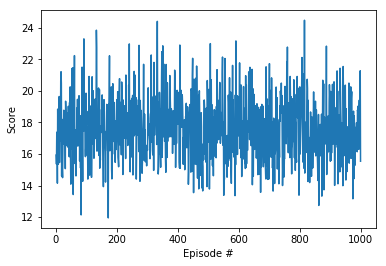

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()